### Data Preprocessing

### Overview

This notebook is used to pre-process the raw football data in the folder `data/raw`. The steps done are:

- Feature engineering, creating new possible relevant columns
- Feature selection using the mRMR algorithm
- Hirearchical cluster analysis to filter out highly correlated relevant features
- Handling missing values

### Pre-requisites 

A conda environment is needed.

For example:
```
cd path/to/conda/dir
conda env create -f aifootball_predictions.yaml
conda activate aifootball_predictions
python -m ipykernel install --user --name aifootball_predictions --display-name "aifootball_predictions"
```

### Authors

- mauo.andretta222@gmail.com

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import os
import mrmr
from mrmr import mrmr_classif
from sklearn.datasets import make_classification
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler


In [2]:
# read all the csv files from the data/raw folder
# walk through the data/raw folder and read all the csv files

directory_path = '../data/raw'  # Replace with your directory path
dataframes = {}

# Walk through the directory and find CSV files
for root, dirs, files in os.walk(directory_path):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            
            # Determine the key and load the dataframe based on the league identifier
            if 'E0' in file:
                dataframes['uk_data'] = pd.read_csv(file_path)
                print(f"Created dataframe: uk_data from {file}")
            elif 'I1' in file:
                dataframes['it_data'] = pd.read_csv(file_path)
                print(f"Created dataframe: it_data from {file}")
            elif 'SP1' in file:
                dataframes['es_data'] = pd.read_csv(file_path)
                print(f"Created dataframe: es_data from {file}")
            elif 'D1' in file:
                dataframes['de_data'] = pd.read_csv(file_path)
                print(f"Created dataframe: de_data from {file}")
            elif 'F1' in file:
                dataframes['fr_data'] = pd.read_csv(file_path)
                print(f"Created dataframe: fr_data from {file}")
            else:
                print(f"File {file} does not match any known league identifier.")

# Access the dataframes
uk_data = dataframes.get('uk_data')
it_data = dataframes.get('it_data')
es_data = dataframes.get('es_data')
de_data = dataframes.get('de_data')
fr_data = dataframes.get('fr_data')          



Created dataframe: de_data from D1_merged.csv
Created dataframe: uk_data from E0_merged.csv
Created dataframe: fr_data from F1_merged.csv
Created dataframe: it_data from I1_merged.csv
Created dataframe: es_data from SP1_merged.csv


In [3]:
valid_feature_names = [
    "Div", "Date", "Time", "HomeTeam", "AwayTeam",
    "FTHG", "FTAG", "FTR", "HTHG", "HTAG", "HTR",
    "Attendance", "Referee", "HS", "AS", "HST", "AST",
    "HHW", "AHW", "HC", "AC", "HF", "AF", "HFKC", "AFKC",
    "HO", "AO", "HY", "AY", "HR", "AR", "HBP", "ABP",
    "B365H", "B365D", "B365A", "BFH", "BFD", "BFA", "BSH", "BSD", "BSA",
    "BWH", "BWD", "BWA", "GBH", "GBD", "GBA", "IWH", "IWD", "IWA",
    "LBH", "LBD", "LBA", "PSH", "PSD", "PSA", "SOH", "SOD", "SOA",
    "SBH", "SBD", "SBA", "SJH", "SJD", "SJA", "SYH", "SYD", "SYA",
    "VCH", "VCD", "VCA", "WHH", "WHD", "WHA",
    "Bb1X2", "BbMxH", "BbAvH", "BbMxD", "BbAvD", "BbMxA", "BbAvA",
    "MaxH", "MaxD", "MaxA", "AvgH", "AvgD", "AvgA",
    "BFEH", "BFED", "BFEA",
    "BbOU", "BbMx>2.5", "BbAv>2.5", "BbMx<2.5", "BbAv<2.5",
    "GB>2.5", "GB<2.5", "B365>2.5", "B365<2.5", "P>2.5", "P<2.5", 
    "Max>2.5", "Max<2.5", "Avg>2.5", "Avg<2.5",
    "BbAH", "BbAHh", "AHh", "BbMxAHH", "BbAvAHH", "BbMxAHA", "BbAvAHA",
    "GBAHH", "GBAHA", "GBAH", "LBAHH", "LBAHA", "LBAH",
    "B365AHH", "B365AHA", "B365AH", "PAHH", "PAHA", "MaxAHH", "MaxAHA", 
    "AvgAHH", "AvgAHA",
    "B365CH", "B365CD", "B365CA", "BWCH", "BWCD", "BWCA",
    "IWCH", "IWCD", "IWCA", "PSCH", "PSCD", "PSCA",
    "WHCH", "WHCD", "WHCA", "VCCH", "VCCD", "VCCA",
    "MaxCH", "MaxCD", "MaxCA", "AvgCH", "AvgCD", "AvgCA"
]


In [4]:
# Show the shape of the uk_data
print(uk_data.shape)


(760, 106)


In [5]:
# Visualize the first few rows of the uk_data dataframe
uk_data.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,11/08/2023,20:00,Burnley,Man City,0,3,A,0,2,...,2.28,1.50,1.95,1.98,1.95,1.97,NaN,NaN,1.92,1.95
1,E0,12/08/2023,12:30,Arsenal,Nott'm Forest,2,1,H,2,0,...,2.63,-2.00,1.95,1.98,1.93,1.97,2.01,2.09,1.95,1.92
2,E0,12/08/2023,15:00,Bournemouth,West Ham,1,1,D,0,0,...,2.12,0.00,2.02,1.91,2.01,1.92,2.06,1.96,1.96,1.91
3,E0,12/08/2023,15:00,Brighton,Luton,4,1,H,1,0,...,2.48,-1.75,2.01,1.92,2.00,1.91,2.14,1.93,2.00,1.86
4,E0,12/08/2023,15:00,Everton,Fulham,0,1,A,0,0,...,1.71,-0.25,2.06,1.87,2.04,1.88,2.08,1.99,1.98,1.88


In [6]:
# show all the columns in the uk_data dataframe
uk_data.columns.tolist()

['Div',
 'Date',
 'Time',
 'HomeTeam',
 'AwayTeam',
 'FTHG',
 'FTAG',
 'FTR',
 'HTHG',
 'HTAG',
 'HTR',
 'Referee',
 'HS',
 'AS',
 'HST',
 'AST',
 'HF',
 'AF',
 'HC',
 'AC',
 'HY',
 'AY',
 'HR',
 'AR',
 'B365H',
 'B365D',
 'B365A',
 'BWH',
 'BWD',
 'BWA',
 'IWH',
 'IWD',
 'IWA',
 'PSH',
 'PSD',
 'PSA',
 'WHH',
 'WHD',
 'WHA',
 'VCH',
 'VCD',
 'VCA',
 'MaxH',
 'MaxD',
 'MaxA',
 'AvgH',
 'AvgD',
 'AvgA',
 'B365>2.5',
 'B365<2.5',
 'P>2.5',
 'P<2.5',
 'Max>2.5',
 'Max<2.5',
 'Avg>2.5',
 'Avg<2.5',
 'AHh',
 'B365AHH',
 'B365AHA',
 'PAHH',
 'PAHA',
 'MaxAHH',
 'MaxAHA',
 'AvgAHH',
 'AvgAHA',
 'B365CH',
 'B365CD',
 'B365CA',
 'BWCH',
 'BWCD',
 'BWCA',
 'IWCH',
 'IWCD',
 'IWCA',
 'PSCH',
 'PSCD',
 'PSCA',
 'WHCH',
 'WHCD',
 'WHCA',
 'VCCH',
 'VCCD',
 'VCCA',
 'MaxCH',
 'MaxCD',
 'MaxCA',
 'AvgCH',
 'AvgCD',
 'AvgCA',
 'B365C>2.5',
 'B365C<2.5',
 'PC>2.5',
 'PC<2.5',
 'MaxC>2.5',
 'MaxC<2.5',
 'AvgC>2.5',
 'AvgC<2.5',
 'AHCh',
 'B365CAHH',
 'B365CAHA',
 'PCAHH',
 'PCAHA',
 'MaxCAHH',
 'MaxCAHA

In [7]:
# Create a season column to identify the season of the match
# Define a function to determine the season based on the date
def determine_season(date):
    year = date.year
    if date.month >= 8:  # Assuming the season starts in August
        return f"{year}/{year + 1}"
    else:
        return f"{year - 1}/{year}"
    
uk_data['Date'] = pd.to_datetime(uk_data['Date'], format='%d/%m/%Y')
uk_data['Season'] = uk_data['Date'].apply(determine_season)

In [8]:
# Show the first few rows of the uk_data dataframe
uk_data.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,Season
0,E0,2023-08-11,20:00,Burnley,Man City,0,3,A,0,2,...,1.50,1.95,1.98,1.95,1.97,NaN,NaN,1.92,1.95,2023/2024
1,E0,2023-08-12,12:30,Arsenal,Nott'm Forest,2,1,H,2,0,...,-2.00,1.95,1.98,1.93,1.97,2.01,2.09,1.95,1.92,2023/2024
2,E0,2023-08-12,15:00,Bournemouth,West Ham,1,1,D,0,0,...,0.00,2.02,1.91,2.01,1.92,2.06,1.96,1.96,1.91,2023/2024
3,E0,2023-08-12,15:00,Brighton,Luton,4,1,H,1,0,...,-1.75,2.01,1.92,2.00,1.91,2.14,1.93,2.00,1.86,2023/2024
4,E0,2023-08-12,15:00,Everton,Fulham,0,1,A,0,0,...,-0.25,2.06,1.87,2.04,1.88,2.08,1.99,1.98,1.88,2023/2024


## Feature Engineering

In [9]:
# create the target variable Over2.5 
uk_data["Over2.5"] = np.where(uk_data["FTHG"] + uk_data["FTAG"] > 2, 1, 0)

# Group by HomeTeam and calculate the average Full Time Home Goals
uk_data['AvgHomeGoalsScored'] = uk_data.groupby(['Season', 'HomeTeam'])['FTHG'].transform('mean').round(2)

# Group by AwayTeam and calculate the average Full Time Away Goals
uk_data['AvgAwayGoalsScored'] = uk_data.groupby(['Season', 'AwayTeam'])['FTAG'].transform('mean').round(2)

# Group by HomeTeam and calculate the average Full Time Away Goals (which are the goals conceded by HomeTeam)
uk_data['AvgHomeGoalsConceded'] = uk_data.groupby(['Season', 'HomeTeam'])['FTAG'].transform('mean').round(2)

# Group by AwayTeam and calculate the average Full Time Home Goals (which are the goals conceded by AwayTeam)
uk_data['AvgAwayGoalsConceded'] = uk_data.groupby(['Season', 'AwayTeam'])['FTHG'].transform('mean').round(2)

# Group by HomeTeam and calculate the percentage of games with Over 2.5 goals
uk_data['HomeOver2.5Perc'] = (uk_data.groupby(['Season', 'HomeTeam'])['Over2.5'].transform('mean') * 100).round(2)

# Group by HomeTeam and calculate the percentage of games with Over 2.5 goals
uk_data['AwayOver2.5Perc'] = (uk_data.groupby(['Season', 'AwayTeam'])['Over2.5'].transform('mean') * 100).round(2)

# Sort the dataframe by HomeTeam and Date
uk_data = uk_data.sort_values(by=['HomeTeam', 'Date'])

# Create a rolling average of the last 5 games for the Full Time Home Goals
uk_data['AvgLast5HomeGoalsScored'] = uk_data.groupby(['Season', 'HomeTeam'])['FTHG'].transform(
    lambda x: x.rolling(5, min_periods=1).mean()).round(2)

uk_data['AvgLast5HomeGoalsConceded'] = uk_data.groupby(['Season', 'HomeTeam'])['FTAG'].transform(
    lambda x: x.rolling(5, min_periods=1).mean()).round(2)

# Create a rolling sum of the last 5 games for Over 2.5 goals for home matches
uk_data['Last5HomeOver2.5Count'] = uk_data.groupby(['Season', 'HomeTeam'])['Over2.5'].transform(
    lambda x: x.rolling(5, min_periods=1).sum()).round(2)

# Calculate the percentage of Over 2.5 goals in the last 5 home matches
uk_data['Last5HomeOver2.5Perc'] = uk_data.groupby(['Season', 'HomeTeam'])['Over2.5'].transform(
    lambda x: x.rolling(5, min_periods=1).mean() * 100).round(2)

# Sort the dataframe by HomeTeam and Date
uk_data = uk_data.sort_values(by=['AwayTeam', 'Date'])

# Create a rolling average of the last 5 games for the Full Time Away Goals
uk_data['AvgLast5AwayGoalsScored'] = uk_data.groupby(['Season', 'AwayTeam'])['FTAG'].transform(lambda x: x.rolling(5, min_periods=1).mean()).round(2)

uk_data['AvgLast5AwayGoalsConceded'] = uk_data.groupby(['Season', 'AwayTeam'])['FTHG'].transform(
    lambda x: x.rolling(5, min_periods=1).mean()).round(2)

# Create a rolling sum of the last 5 games for Over 2.5 goals for away matches
uk_data['Last5AwayOver2.5Count'] = uk_data.groupby(['Season', 'AwayTeam'])['Over2.5'].transform(lambda x: x.rolling(5, min_periods=1).sum()).round(2)

# Create a rolling sum of the last 5 games for Over 2.5 goals for away matches
uk_data['Last5AwayOver2.5Perc'] = uk_data.groupby(['Season', 'AwayTeam'])['Over2.5'].transform(lambda x: x.rolling(5, min_periods=1).mean() * 100).round(2)


In [10]:
uk_data.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,HomeOver2.5Perc,AwayOver2.5Perc,AvgLast5HomeGoalsScored,AvgLast5HomeGoalsConceded,Last5HomeOver2.5Count,Last5HomeOver2.5Perc,AvgLast5AwayGoalsScored,AvgLast5AwayGoalsConceded,Last5AwayOver2.5Count,Last5AwayOver2.5Perc
380,E0,2022-08-05,20:00,Crystal Palace,Arsenal,0,2,A,0,1,...,42.11,47.37,0.0,2.00,0.0,0.0,2.00,0.00,0.0,0.00
405,E0,2022-08-20,17:30,Bournemouth,Arsenal,0,3,A,0,2,...,47.37,47.37,1.0,1.50,1.0,50.0,2.50,0.00,1.0,50.00
439,E0,2022-09-04,16:30,Man United,Arsenal,3,1,H,1,0,...,57.89,47.37,2.0,1.33,3.0,100.0,2.00,1.00,2.0,66.67
445,E0,2022-09-18,12:00,Brentford,Arsenal,0,3,A,0,2,...,47.37,47.37,2.5,1.50,3.0,75.0,2.25,0.75,3.0,75.00
473,E0,2022-10-16,14:00,Leeds,Arsenal,0,1,A,0,1,...,63.16,47.37,1.2,0.60,2.0,40.0,2.00,0.60,3.0,60.00


## Feature Selection

In [11]:
# shoe the shape of the uk_data dataframe before dropping the missing values
uk_data.shape

(760, 122)

In [12]:
# define a list of useless comlumns to drop
useless_columns = ['FTHG', 'FTAG', 'HTHG', 'HTAG'] 
# All the features related to the goals scored in a match, are higly biasing for the model, so we can drop them


# Drop the useless columns from the uk_data dataframe
# check if the columns are in the dataframe before dropping them
for column in useless_columns:
    if column in uk_data.columns:
        uk_data.drop(column, axis=1, inplace=True)
    else:
        print(f"Column {column} not found in the dataframe")

In [13]:
# Create a list of all the columns that are not of type object
numerical_columns = uk_data.drop(["Date"], axis=1).select_dtypes(exclude='object').columns.tolist()
numerical_columns

['HS',
 'AS',
 'HST',
 'AST',
 'HF',
 'AF',
 'HC',
 'AC',
 'HY',
 'AY',
 'HR',
 'AR',
 'B365H',
 'B365D',
 'B365A',
 'BWH',
 'BWD',
 'BWA',
 'IWH',
 'IWD',
 'IWA',
 'PSH',
 'PSD',
 'PSA',
 'WHH',
 'WHD',
 'WHA',
 'VCH',
 'VCD',
 'VCA',
 'MaxH',
 'MaxD',
 'MaxA',
 'AvgH',
 'AvgD',
 'AvgA',
 'B365>2.5',
 'B365<2.5',
 'P>2.5',
 'P<2.5',
 'Max>2.5',
 'Max<2.5',
 'Avg>2.5',
 'Avg<2.5',
 'AHh',
 'B365AHH',
 'B365AHA',
 'PAHH',
 'PAHA',
 'MaxAHH',
 'MaxAHA',
 'AvgAHH',
 'AvgAHA',
 'B365CH',
 'B365CD',
 'B365CA',
 'BWCH',
 'BWCD',
 'BWCA',
 'IWCH',
 'IWCD',
 'IWCA',
 'PSCH',
 'PSCD',
 'PSCA',
 'WHCH',
 'WHCD',
 'WHCA',
 'VCCH',
 'VCCD',
 'VCCA',
 'MaxCH',
 'MaxCD',
 'MaxCA',
 'AvgCH',
 'AvgCD',
 'AvgCA',
 'B365C>2.5',
 'B365C<2.5',
 'PC>2.5',
 'PC<2.5',
 'MaxC>2.5',
 'MaxC<2.5',
 'AvgC>2.5',
 'AvgC<2.5',
 'AHCh',
 'B365CAHH',
 'B365CAHA',
 'PCAHH',
 'PCAHA',
 'MaxCAHH',
 'MaxCAHA',
 'AvgCAHH',
 'AvgCAHA',
 'Over2.5',
 'AvgHomeGoalsScored',
 'AvgAwayGoalsScored',
 'AvgHomeGoalsConceded',
 'AvgA

In [15]:
#categorical columns
categorical_columns = uk_data.select_dtypes(include='object').columns.tolist()
categorical_columns

['Div', 'Time', 'HomeTeam', 'AwayTeam', 'FTR', 'HTR', 'Referee', 'Season']

### mRMR features selection

In [16]:
X = uk_data[numerical_columns].drop(["Over2.5"], axis=1)
y = uk_data["Over2.5"]

# select top 10 features using mRMR
selected_features = mrmr_classif(X=X, y=y, K=20)

100%|██████████| 20/20 [00:01<00:00, 14.09it/s]


In [17]:
selected_features

['Last5HomeOver2.5Perc',
 'Last5AwayOver2.5Perc',
 'HST',
 'Last5HomeOver2.5Count',
 'Last5AwayOver2.5Count',
 'AST',
 'HomeOver2.5Perc',
 'AvgLast5AwayGoalsConceded',
 'AvgLast5HomeGoalsScored',
 'AwayOver2.5Perc',
 'AvgLast5HomeGoalsConceded',
 'AvgLast5AwayGoalsScored',
 'PC<2.5',
 'B365C>2.5',
 'MaxC>2.5',
 'PC>2.5',
 'AvgC>2.5',
 'B365C<2.5',
 'HR',
 'Max>2.5']

Standardize the feature to help the hierarchical clustering in removing the higly correlated features

In [18]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(uk_data[selected_features])

In [19]:
#create a panda frame of the scaled data
uk_scaled_data = pd.DataFrame(scaled_features, columns=selected_features)
#replace the original data with the scaled data
uk_data[selected_features] = uk_scaled_data

In [20]:
uk_data.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTR,HTR,Referee,HS,AS,...,HomeOver2.5Perc,AwayOver2.5Perc,AvgLast5HomeGoalsScored,AvgLast5HomeGoalsConceded,Last5HomeOver2.5Count,Last5HomeOver2.5Perc,AvgLast5AwayGoalsScored,AvgLast5AwayGoalsConceded,Last5AwayOver2.5Count,Last5AwayOver2.5Perc
380,E0,2022-08-05,20:00,Crystal Palace,Arsenal,A,A,A Taylor,10,10,...,2.064604,0.366732,2.674833,1.003127,-1.257582,1.557803,1.024532,2.975434,-1.343175,1.692089
405,E0,2022-08-20,17:30,Bournemouth,Arsenal,A,A,C Pawson,6,14,...,-0.053214,0.797723,0.105302,-0.183013,0.302846,0.060184,0.110058,-0.647476,0.319387,0.067512
439,E0,2022-09-04,16:30,Man United,Arsenal,H,H,P Tierney,10,16,...,0.300203,1.228715,-1.413058,0.261790,-1.257582,-0.314221,-1.520755,1.254552,-0.511894,0.338411
445,E0,2022-09-18,12:00,Brentford,Arsenal,A,A,D Coote,5,13,...,1.711858,1.228715,-0.595480,0.706592,0.302846,0.060184,0.110058,0.646420,1.150668,0.879801
473,E0,2022-10-16,14:00,Leeds,Arsenal,A,A,C Kavanagh,16,9,...,-0.405960,-0.927062,0.806083,0.113522,0.302846,0.060184,1.329357,-1.423814,0.319387,0.067512


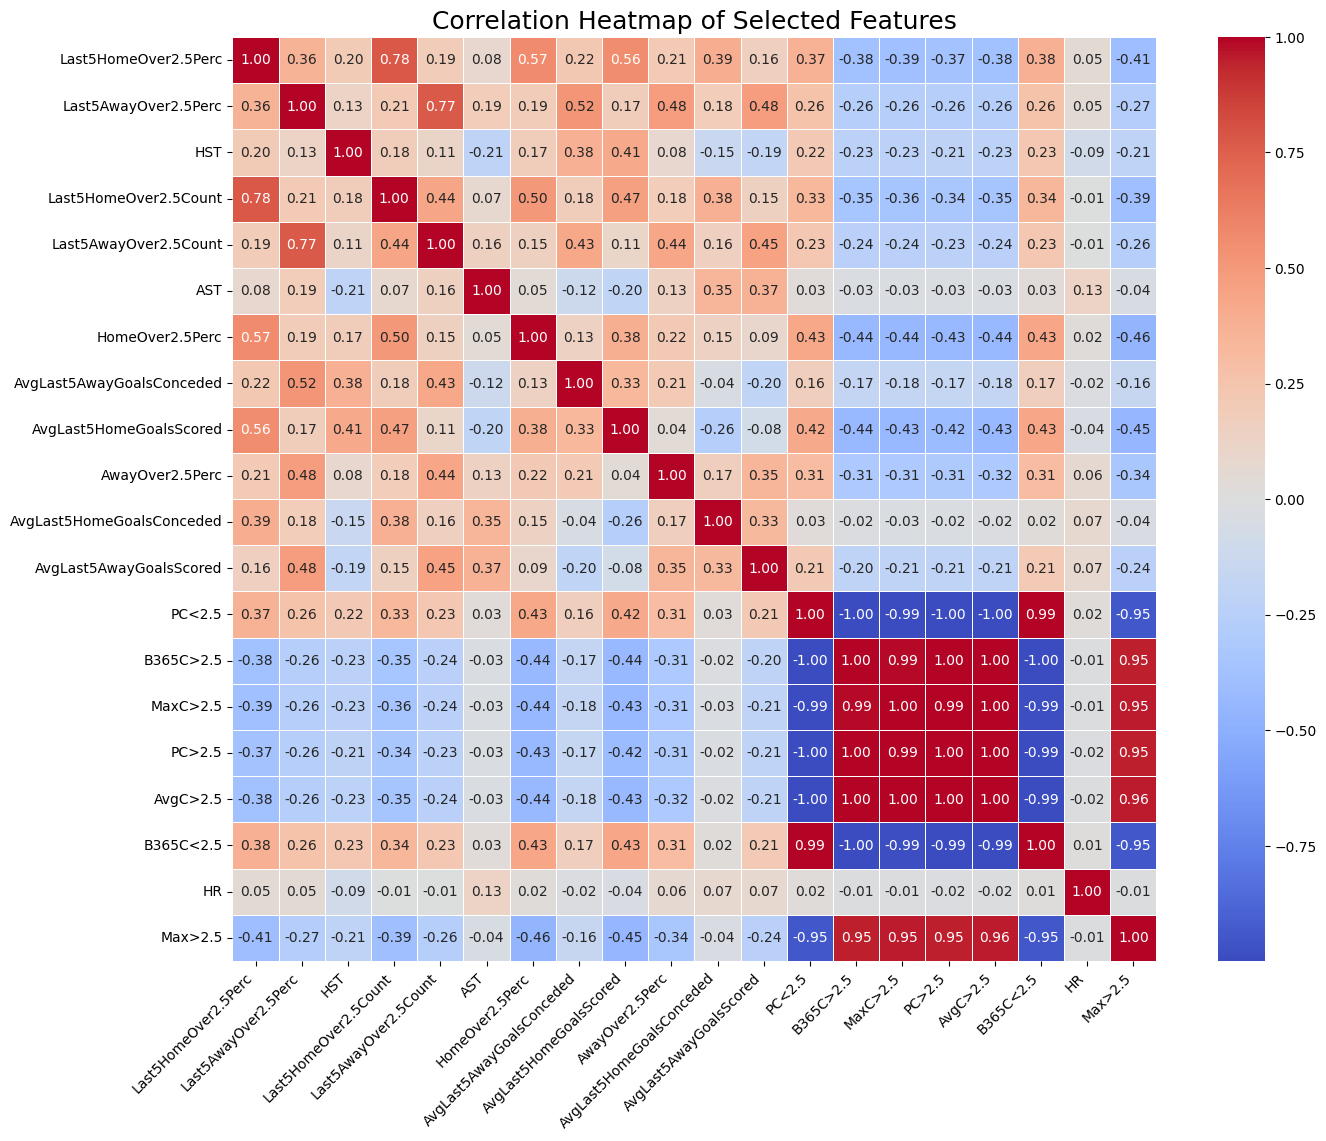

In [21]:
# show the correlation matrix of the selected features
# Calculate the correlation matrix
corr_matrix = uk_data[selected_features].corr(method='spearman')

# Create a heatmap
plt.figure(figsize=(16, 12))  # Adjust the size to fit the data
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, annot_kws={"size": 10},
            linewidths=0.5, linecolor='white', square=True)

# Customize the plot
plt.title('Correlation Heatmap of Selected Features', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Show the plot
plt.show()



### Feature Grouping and Selection

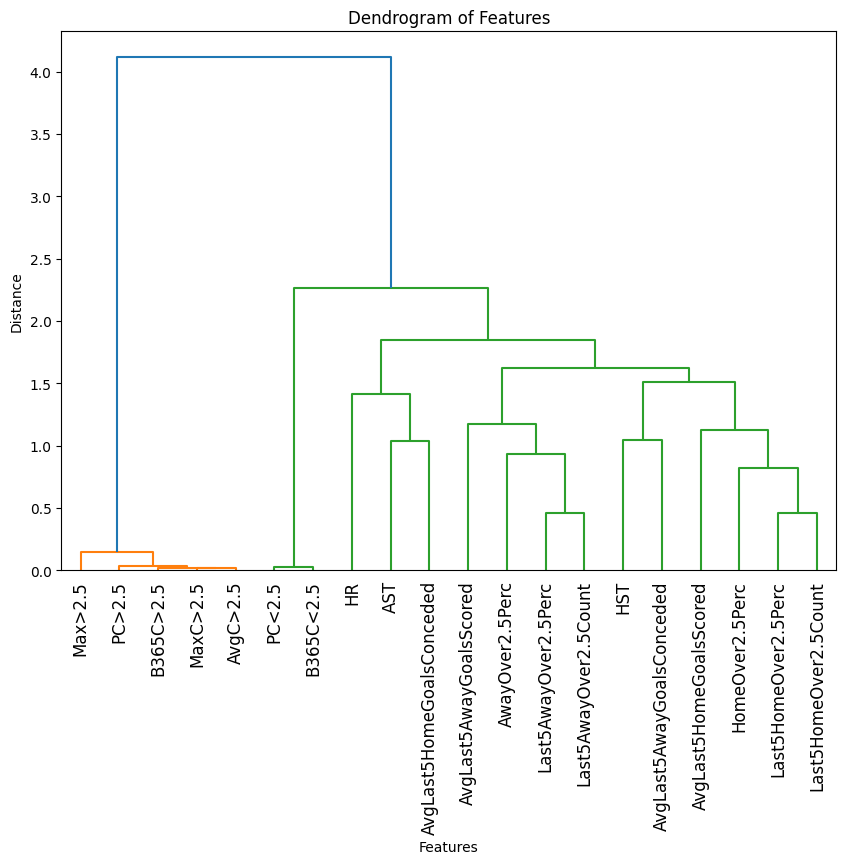

In [23]:
# Compute the distance matrix (1 - correlation)
dist = sch.distance.pdist(corr_matrix, metric='euclidean')

# Perform hierarchical clustering
linkage = sch.linkage(dist, method='average')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(linkage, labels=corr_matrix.columns, leaf_rotation=90)
plt.title('Dendrogram of Features')
plt.xlabel('Features')
plt.ylabel('Distance')
plt.show()

In [24]:

# Apply a threshold to form flat clusters
"""
The fcluster function is typically used when you want to automate 
the process of defining clusters based on a specific threshold distance, 
rather than manually inspecting the dendrogram.
"""
cluster_ids = sch.fcluster(linkage, 0.5, criterion='distance')


# Select the feature with the highest variance within each cluster
selected_features_clustered = []
for cluster_id in pd.Series(cluster_ids).unique():
    cluster_features = corr_matrix.columns[pd.Series(cluster_ids) == cluster_id]
    # Select the feature with the highest variance
    highest_variance_feature = cluster_features[np.argmax(uk_data[cluster_features].var())]
    selected_features_clustered.append(highest_variance_feature)

print("Selected features after clustering:", selected_features_clustered)


Selected features after clustering: ['Last5HomeOver2.5Perc', 'Last5AwayOver2.5Perc', 'HST', 'AST', 'HomeOver2.5Perc', 'AvgLast5AwayGoalsConceded', 'AvgLast5HomeGoalsScored', 'AwayOver2.5Perc', 'AvgLast5HomeGoalsConceded', 'AvgLast5AwayGoalsScored', 'PC<2.5', 'PC>2.5', 'HR']


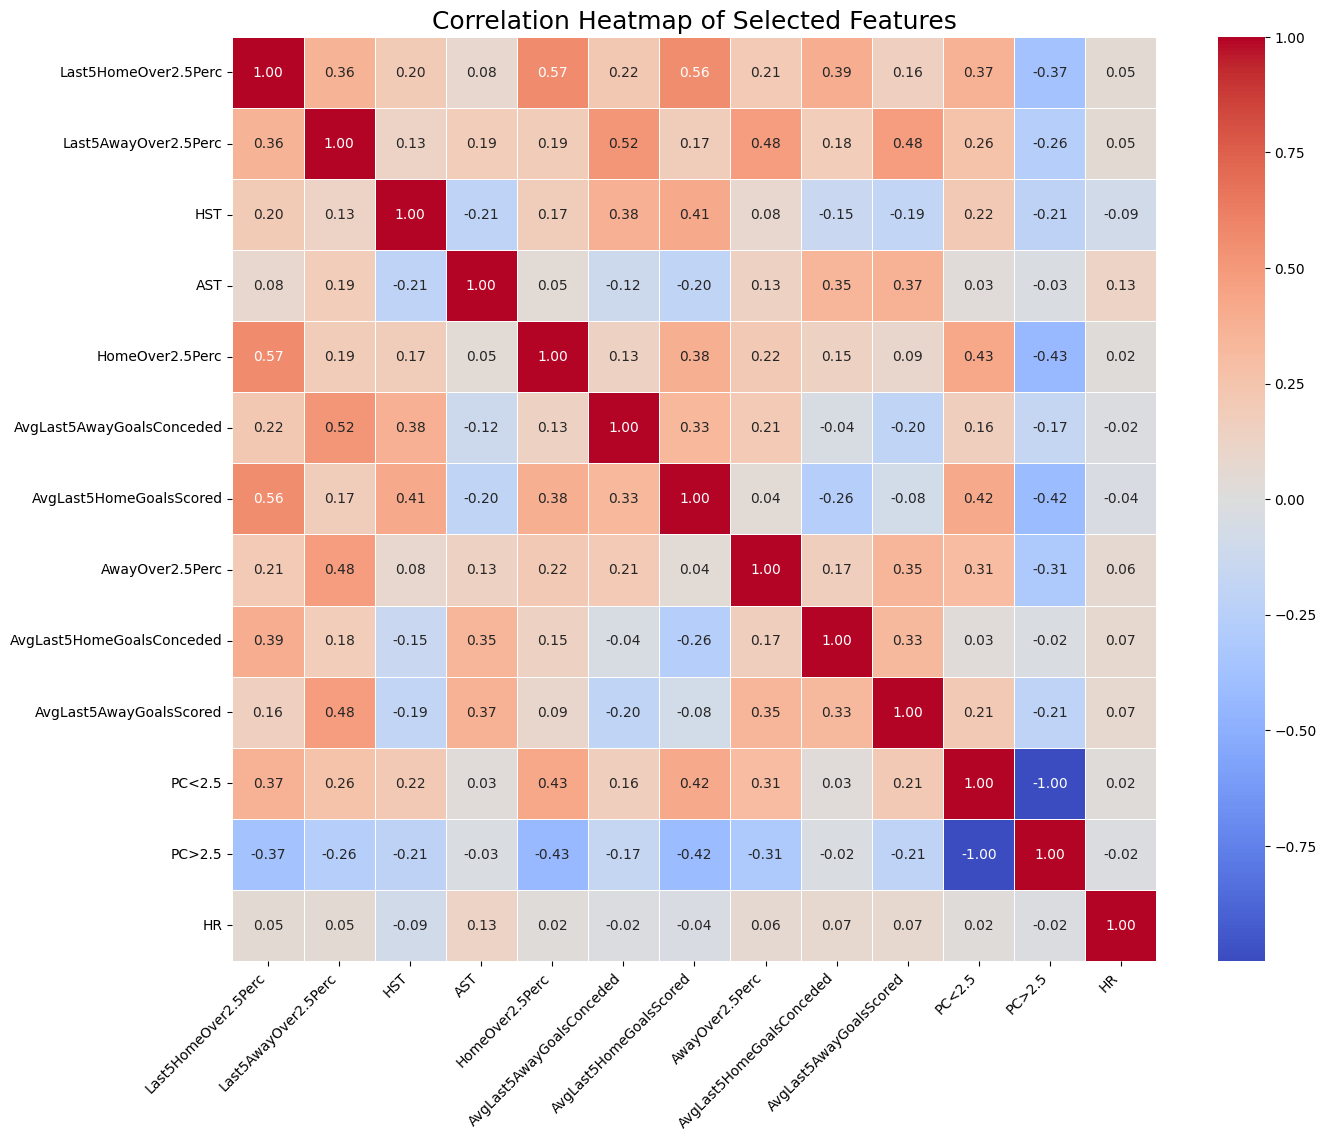

In [25]:
# show the correlation matrix of the selected features
# Calculate the correlation matrix
corr_matrix = uk_data[selected_features_clustered].corr(method='spearman')

# Create a heatmap
plt.figure(figsize=(16, 12))  # Adjust the size to fit the data
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, annot_kws={"size": 10},
            linewidths=0.5, linecolor='white', square=True)

# Customize the plot
plt.title('Correlation Heatmap of Selected Features', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Show the plot
plt.show()

In [105]:
# Print the selected features, the selected feature cluster
# and the feature selected by the mRMR algorithm but not in the selected feature cluster
print("Selected features:", selected_features)
print("Selected features after clustering:", selected_features_clustered)
print("Features selected by mRMR but not in the selected feature cluster:", list(set(selected_features) - set(selected_features_clustered)))

Selected features: ['Last5HomeOver2.5Perc', 'Last5AwayOver2.5Perc', 'HST', 'Last5HomeOver2.5Count', 'Last5AwayOver2.5Count', 'AST', 'HomeOver2.5Perc', 'AvgLast5AwayGoalsConceded', 'AvgLast5HomeGoalsScored', 'AwayOver2.5Perc', 'AvgLast5HomeGoalsConceded', 'AvgLast5AwayGoalsScored', 'PC<2.5', 'B365C>2.5', 'MaxC>2.5', 'PC>2.5', 'AvgC>2.5', 'B365C<2.5', 'HR', 'Max>2.5']
Selected features after clustering: ['Last5HomeOver2.5Perc', 'Last5AwayOver2.5Perc', 'HST', 'AST', 'HomeOver2.5Perc', 'AvgLast5AwayGoalsConceded', 'AvgLast5HomeGoalsScored', 'AwayOver2.5Perc', 'AvgLast5HomeGoalsConceded', 'AvgLast5AwayGoalsScored', 'PC<2.5', 'B365C>2.5', 'HR']
Features selected by mRMR but not in the selected feature cluster: ['Last5HomeOver2.5Count', 'PC>2.5', 'Max>2.5', 'B365C<2.5', 'AvgC>2.5', 'MaxC>2.5', 'Last5AwayOver2.5Count']


In [26]:
# create a new dataframe with the selected features
uk_data_selected = uk_data[["Date"] + categorical_columns + selected_features_clustered + ['Over2.5']]

In [27]:
# check the shape of the new dataframe
uk_data_selected.shape

(760, 23)

In [28]:
# Check for missing values in each column
missing_values_count = uk_data_selected.isnull().sum()
print("Missing values in each column:\n", missing_values_count)

Missing values in each column:
 Date                         0
Div                          0
Time                         0
HomeTeam                     0
AwayTeam                     0
FTR                          0
HTR                          0
Referee                      0
Season                       0
Last5HomeOver2.5Perc         0
Last5AwayOver2.5Perc         0
HST                          0
AST                          0
HomeOver2.5Perc              0
AvgLast5AwayGoalsConceded    0
AvgLast5HomeGoalsScored      0
AwayOver2.5Perc              0
AvgLast5HomeGoalsConceded    0
AvgLast5AwayGoalsScored      0
PC<2.5                       8
PC>2.5                       8
HR                           0
Over2.5                      0
dtype: int64


In [29]:
# Set the threshold for the maximum allowed counts of missing values
threshold = 10  # For example, 10

# Identify columns to drop
columns_to_drop = missing_values_count[missing_values_count > threshold].index
print("\nColumns to drop due to excessive missing values:\n", columns_to_drop)


Columns to drop due to excessive missing values:
 Index([], dtype='object')


In [30]:
# Drop the columns with too many missing values
uk_data_selected = uk_data_selected.drop(columns=columns_to_drop)

In [31]:
# Drop rows with any missing values
uk_data_selected = uk_data_selected.dropna()

# Check if there are any remaining missing values
print("\nRemaining missing values:\n", uk_data_selected.isnull().sum())



Remaining missing values:
 Date                         0
Div                          0
Time                         0
HomeTeam                     0
AwayTeam                     0
FTR                          0
HTR                          0
Referee                      0
Season                       0
Last5HomeOver2.5Perc         0
Last5AwayOver2.5Perc         0
HST                          0
AST                          0
HomeOver2.5Perc              0
AvgLast5AwayGoalsConceded    0
AvgLast5HomeGoalsScored      0
AwayOver2.5Perc              0
AvgLast5HomeGoalsConceded    0
AvgLast5AwayGoalsScored      0
PC<2.5                       0
PC>2.5                       0
HR                           0
Over2.5                      0
dtype: int64


In [32]:
# show the final uk_data_selected dataframe
uk_data_selected.head()

,Date,Div,Time,HomeTeam,AwayTeam,FTR,HTR,Referee,Season,Last5HomeOver2.5Perc,...,HomeOver2.5Perc,AvgLast5AwayGoalsConceded,AvgLast5HomeGoalsScored,AwayOver2.5Perc,AvgLast5HomeGoalsConceded,AvgLast5AwayGoalsScored,PC<2.5,PC>2.5,HR,Over2.5
380,2022-08-05,E0,20:00,Crystal Palace,Arsenal,A,A,A Taylor,2022/2023,1.557803,...,2.064604,2.975434,2.674833,0.366732,1.003127,1.024532,-0.116942,-0.197121,-0.236737,0
405,2022-08-20,E0,17:30,Bournemouth,Arsenal,A,A,C Pawson,2022/2023,0.060184,...,-0.053214,-0.647476,0.105302,0.797723,-0.183013,0.110058,0.097181,-0.374520,-0.236737,1
439,2022-09-04,E0,16:30,Man United,Arsenal,H,H,P Tierney,2022/2023,-0.314221,...,0.300203,1.254552,-1.413058,1.228715,0.261790,-1.520755,-1.123320,1.399474,-0.236737,1
445,2022-09-18,E0,12:00,Brentford,Arsenal,A,A,D Coote,2022/2023,0.060184,...,1.711858,0.646420,-0.595480,1.228715,0.706592,0.110058,-1.187557,1.541394,-0.236737,1
473,2022-10-16,E0,14:00,Leeds,Arsenal,A,A,C Kavanagh,2022/2023,0.060184,...,-0.405960,-1.423814,0.806083,-0.927062,0.113522,1.329357,0.975085,-1.048638,-0.236737,0
